In [21]:
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_scatter import scatter_add
import matplotlib.pyplot as plt
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.nn import NNConv
from torch_geometric.utils import to_networkx

import networkx as nx

In [113]:
class PhysicsInformedGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, edge_attr_dim):
        super(PhysicsInformedGCN, self).__init__()
        
        def make_nn(in_features, out_features):
            return nn.Sequential(
                nn.Linear(edge_attr_dim, in_features * out_features),
                nn.ReLU(),
                nn.Linear(in_features * out_features, in_features * out_features)
            )
        
        self.conv1 = NNConv(in_channels, hidden_channels, make_nn(in_channels, hidden_channels), aggr='mean')
        self.conv2 = NNConv(hidden_channels, hidden_channels, make_nn(hidden_channels, hidden_channels), aggr='mean')
        self.conv3 = NNConv(hidden_channels, hidden_channels, make_nn(hidden_channels, hidden_channels), aggr='mean')
        self.conv4 = NNConv(hidden_channels, hidden_channels, make_nn(hidden_channels, hidden_channels), aggr='mean')
        self.conv5 = NNConv(hidden_channels, out_channels, make_nn(hidden_channels, out_channels), aggr='mean')
        
        self.tanh = nn.Tanh()
    
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.tanh(self.conv1(x, edge_index, edge_attr))
        x = self.tanh(self.conv2(x, edge_index, edge_attr))
        x = self.tanh(self.conv3(x, edge_index, edge_attr))
        x = self.tanh(self.conv4(x, edge_index, edge_attr))
        x = self.conv5(x, edge_index, edge_attr)
        return x

In [114]:
L = 1.0
num_nodes = 20
dx = L / (num_nodes - 1)

node_pos = torch.tensor([[i*dx] for i in range(num_nodes)], dtype=torch.float, requires_grad=True)
edge_index = []
for i in range(num_nodes - 1):
    edge_index.append([i, i + 1]) # Forward connection
    edge_index.append([i + 1, i]) # Backward connection (undirected graph)

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

edge_attr = torch.tensor([dx] * edge_index.shape[1], dtype=torch.float).view(-1, 1)

beam_graph = Data(x=node_pos, edge_index=edge_index, edge_attr=edge_attr)

print(beam_graph)

Data(x=[20, 1], edge_index=[2, 38], edge_attr=[38, 1])


In [115]:
G = to_networkx(beam_graph, to_undirected=True)

pos = {i: (beam_graph.x[i].item(), 0.0) for i in range(beam_graph.x.shape[0])}

# nx.draw(G, pos, node_size=20)

# plt.show()

In [116]:
in_channels = 1
hidden_channels = 32
out_channels = 2
edge_attr_dim = 1

model = PhysicsInformedGCN(in_channels, hidden_channels, out_channels, edge_attr_dim)

In [117]:

def loss_func(data):
    out = model(data)
    
    u = out[:, 0:1]
    m = out[:, 1:2]

    u_x = torch.autograd.grad(u, data.x, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_2x = torch.autograd.grad(u_x, data.x, torch.ones_like(u_x), create_graph=True)[0]

    m_x = torch.autograd.grad(m, data.x, torch.ones_like(m), create_graph=True, retain_graph=True)[0]
    m_2x = torch.autograd.grad(m_x, data.x, torch.ones_like(m_x), create_graph=True)[0]

    pde_loss = torch.mean(torch.pow(m_2x - 1, 2))
    pde_loss = torch.mean(torch.pow(u_2x + m, 2))


    bc_loss = u[0]**2 + u_x[0]**2
    bc_loss += m[-1]**2 + m_x[-1]**2

    return pde_loss, bc_loss[0]

In [118]:
pde, bc = loss_func(beam_graph)
print(pde, bc)

tensor(7.8383, grad_fn=<MeanBackward0>) tensor(3.2727, grad_fn=<SelectBackward0>)


In [119]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(epochs=1000):
    for epoch in range(epochs):
        optimizer.zero_grad()

        pde, bc = loss_func(beam_graph)
        loss = bc
        loss.backward()

        optimizer.step()
        if epoch % 20 == 0:
            print(f"Epoch: {epoch}, Loss: {'{:e}'.format(loss.item())}")
            print(f"PDE: {'{:e}'.format(pde.item())}, BC: {'{:e}'.format(bc.item())}")


In [120]:
print(model)

PhysicsInformedGCN(
  (conv1): NNConv(1, 32, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (conv2): NNConv(32, 32, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
  ))
  (conv3): NNConv(32, 32, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
  ))
  (conv4): NNConv(32, 32, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
  ))
  (conv5): NNConv(32, 2, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  ))
  (t

In [121]:

train(200)

Epoch: 0, Loss: 3.272668e+00
PDE: 7.838275e+00, BC: 3.272668e+00
Epoch: 20, Loss: 1.239640e+00
PDE: 7.949299e-01, BC: 1.239640e+00
Epoch: 40, Loss: 2.335536e-01
PDE: 1.673108e-01, BC: 2.335536e-01
Epoch: 60, Loss: 1.423548e-02
PDE: 1.410337e-02, BC: 1.423548e-02
Epoch: 80, Loss: 1.743451e-03
PDE: 1.286504e-03, BC: 1.743451e-03
Epoch: 100, Loss: 1.626342e-05
PDE: 1.248842e-05, BC: 1.626342e-05
Epoch: 120, Loss: 2.888267e-05
PDE: 1.163595e-05, BC: 2.888267e-05
Epoch: 140, Loss: 8.881062e-06
PDE: 6.279327e-06, BC: 8.881062e-06
Epoch: 160, Loss: 1.162571e-07
PDE: 5.915104e-08, BC: 1.162571e-07
Epoch: 180, Loss: 6.124582e-08
PDE: 1.639095e-08, BC: 6.124582e-08


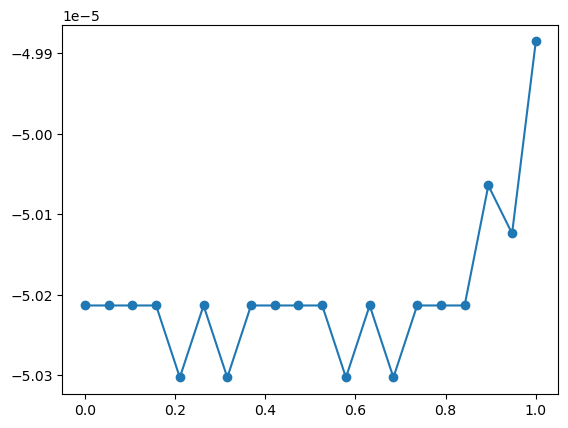

In [122]:
out = model(beam_graph)
u = out[:, 0:1].detach().cpu().numpy()
x = beam_graph.x.detach().cpu().numpy()

plt.plot(x, u, '-o')
plt.show()